<a href="https://colab.research.google.com/github/Morfinic/PWR_1_st.2_UM/blob/master/P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers, Sequential
from IPython.display import Image

!pip install numba
from numba import cuda

Poniższy blok pobiera dataset z Kaggle. Po uruchomieniu możliwe jest wybranie pliku, który posłuży jako klucz dostępu (Konto Kaggle -> Ustawienia -> API/Create new token).

**Datasets**
* https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
* https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images


In [2]:
from google.colab import files
%cd /content
files.upload()

kaggle_path = "cashbowman/ai-generated-images-vs-real-images"

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d $kaggle_path

import zipfile
zip_ref = zipfile.ZipFile(kaggle_path.split('/')[-1] + '.zip', 'r')
zip_ref.extractall('/content/kaggle')
zip_ref.close()

/content


Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images
License(s): Community Data License Agreement - Sharing - Version 1.0
 98% 465M/476M [00:01<00:00, 361MB/s]
100% 476M/476M [00:01<00:00, 408MB/s]


In [3]:
print("Devices: ", tf.config.list_physical_devices())

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
device = cuda.get_current_device()
device.reset()

In [7]:
datasetPath = "/content/kaggle"

imgDim = (256, 256)
batchSize = 16

dataset = tf.keras.utils.image_dataset_from_directory(
    datasetPath,
    label_mode='binary',
    seed=500,
    image_size=imgDim,
    batch_size=batchSize,
    shuffle=True
)

trainingSetSize = 0.8
validationgSetSize = 0.1

datasetSize = len(dataset)
trainBatches = int(datasetSize * trainingSetSize)
validationBatches = int(datasetSize * validationgSetSize) + 1
testingBatches = datasetSize - trainBatches - validationBatches

trainingSet = dataset.take(trainBatches)
validationSet = dataset.skip(trainBatches).take(validationBatches)
testingSet = dataset.skip(trainBatches + validationBatches)

trainingSet = trainingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validationSet = validationSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
testingSet = testingSet.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training set lenght:", len(trainingSet))
print("Validation set lenght:", len(validationSet))
print("Testing set lenght:", len(testingSet))
print("Training classes: ", dataset.class_names)



Found 971 files belonging to 2 classes.
Training set lenght: 48
Validation set lenght: 7
Testing set lenght: 6
Training classes:  ['AiArtData', 'RealArt']


In [8]:
def plotMetrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

classNames = ['FAKE', 'REAL']

---
# VGG16
---

In [9]:
EffNet_base = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    input_shape=(*imgDim, 3),
    include_top=False,
    pooling='max'
)
EffNet_base.trainable = False

x = EffNet_base.output
x = Dense(128, activation="relu")(x)
x = Dropout(
    rate = .5,
    seed = 500
)(x)
output = Dense(1, activation="sigmoid")(x)

EffNet_model = tf.keras.Model(EffNet_base.input, output)

EffNet_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

EffNet_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

print("Starting training at", datetime.now())
EffNet_history = EffNet_model.fit(
    trainingSet,
    validation_data = validationSet,
    epochs = 200,
    verbose = 1,
    callbacks = [early_stopping, lr_scheduler],
    class_weight={0: 0.906, 1: 1.116}
)
print("Finished trainging at", datetime.now())
%cd /content
EffNet_model.save("EffNet-1-gen.keras")
print("Saved trained model")

Starting training at 2025-05-24 15:45:44.857307
Epoch 1/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 676ms/step - accuracy: 0.5442 - loss: 2.4477 - precision: 0.4793 - recall: 0.4972 - val_accuracy: 0.6786 - val_loss: 0.6238 - val_precision: 0.6462 - val_recall: 0.7636 - learning_rate: 0.0010
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6502 - loss: 0.6568 - precision: 0.6020 - recall: 0.5938 - val_accuracy: 0.7589 - val_loss: 0.5785 - val_precision: 0.7500 - val_recall: 0.7636 - learning_rate: 0.0010
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7317 - loss: 0.5620 - precision: 0.7083 - recall: 0.6534 - val_accuracy: 0.7857 - val_loss: 0.5211 - val_precision: 0.8298 - val_recall: 0.7091 - learning_rate: 0.0010
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7222 - loss: 0.5589 - precision: 0.6809 - recall: 0.6900 - val_accuracy: 0.8214 - val_loss: 0.5002 - val_precision: 0.8723 - val_recall: 0.7455 - learning_rate: 0.0010
Epoch 5/200
48

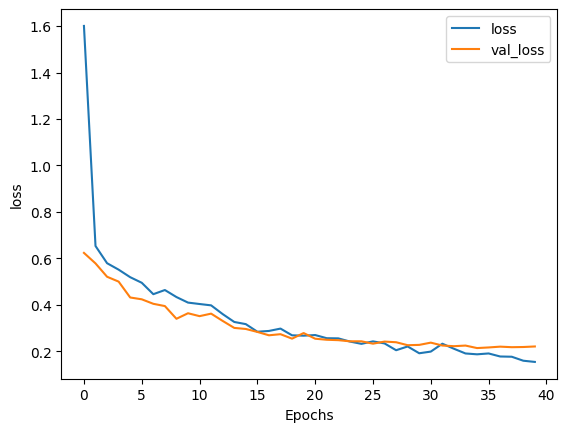

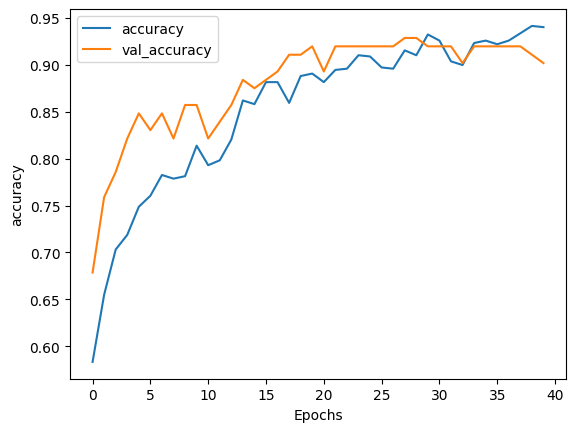

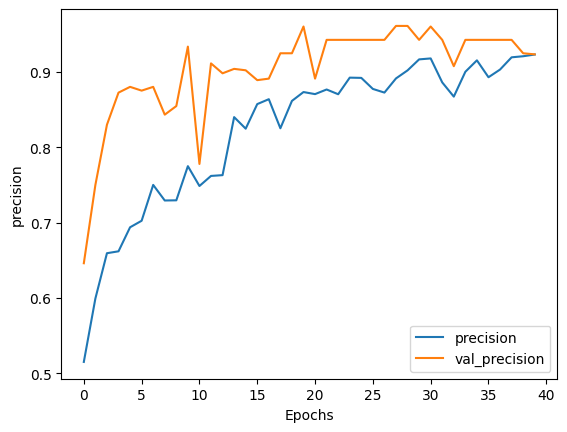

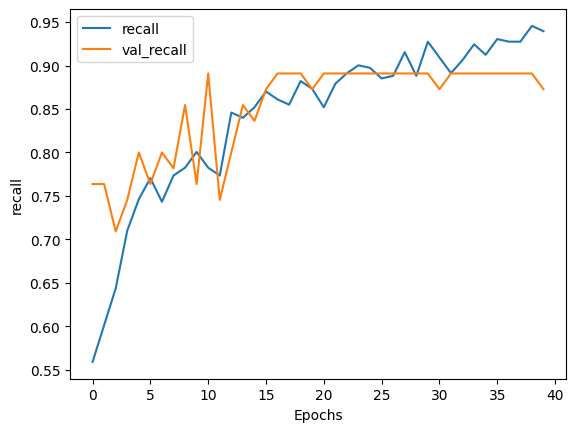

In [11]:
plotMetrics(EffNet_history, "loss")
plotMetrics(EffNet_history, "accuracy")
plotMetrics(EffNet_history, "precision")
plotMetrics(EffNet_history, "recall")

---
# Testing
---

In [12]:
%cd /content
loadedModel = tf.keras.models.load_model("EffNet-1-gen.keras")

/content


In [13]:
val_loss, val_accuracy, val_precision, val_recall = loadedModel.evaluate(testingSet)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8394 - loss: 0.4093 - precision: 0.8764 - recall: 0.8267
Loss: 0.3158
Accuracy: 0.8901
Precision: 0.9130
Recall: 0.8750


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


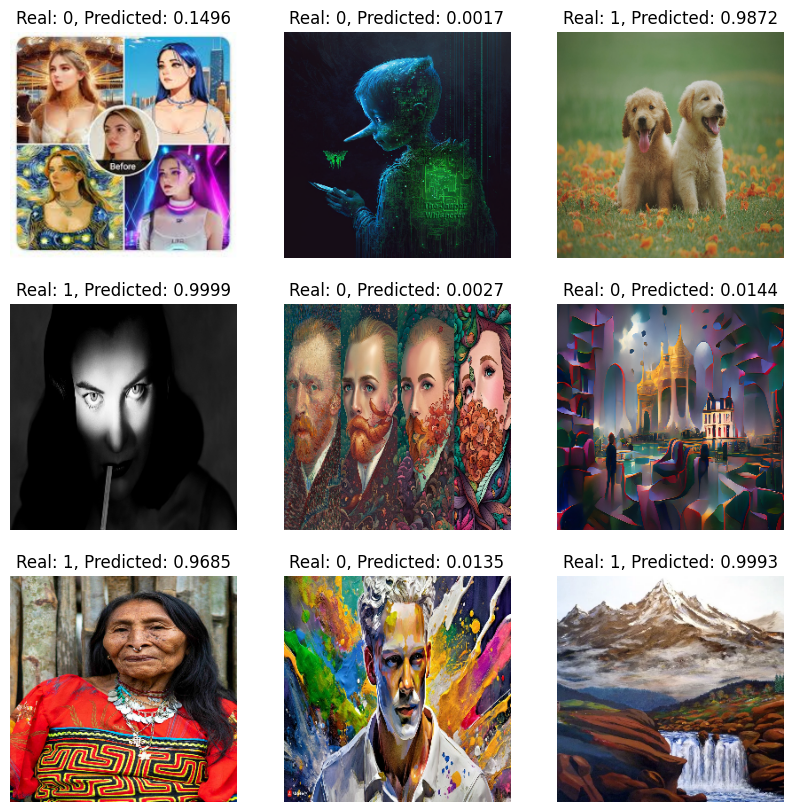

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in trainingSet.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        result = loadedModel.predict(np.expand_dims(np.array(images[i]), axis = 0))
        plt.title(f"Real: {int(labels[i])}, Predicted: {result[0 ,0]:.4f}")
        plt.axis("off")

mkdir: cannot create directory ‘/content/imgTest’: File exists
/content/imgTest


Saving asdasdasd.jpg to asdasdasd.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


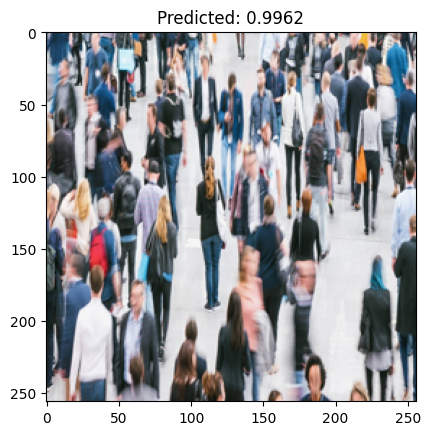

In [19]:
from google.colab import files

!mkdir /content/imgTest
%cd /content/imgTest
uploaded = files.upload()
uploadName = list(uploaded.keys())[0]

with pimg.open(uploadName) as img:
  res = img.resize(imgDim).convert('RGB')
  result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
  plt.title(f"Predicted: {result[0 ,0]:.4f}")
  imgplot = plt.imshow(res)
  plt.show()